이 ipynb 파일을 수행하면, battery 정보를 담은 json파일이 생성됩니다.<br>
이 파일에서 사용자가 직접 입력해줘야 되는 부분은<br>
**'0) battery json 파일을 만들기 전, cell에 경로정보와 추출할 배터리 사이즈 설정**'<br>
입니다.

만약 다른 클래스에 대해 json을 만들고 싶다면,<br>
**'0) battery json 파일을 만들기 전, cell에 경로정보와 추출할 배터리 사이즈 설정**'<br>
에서의 **split_category_id**의 값을 해당 클래스의 category_id로 변경하고<br>
**class_name**을 해당 클래스 name으로 변경해주세요.

In [2]:
import json
from pycocotools.coco import COCO
import os

import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
import random

### 0) battery json 파일을 만들기 전, 경로정보와 추출할 배터리 사이즈 설정

In [15]:
# 1.이미지가 들어있는 dataset folder (변경할 필요없음)
dataset_folder = "/opt/ml/segmentation/input/data/"
# 2.사용하는 train.json 경로 
train_json_path = "/opt/ml/segmentation/semantic-segmentation-level2-cv-13/splited_json/train_split_0.json"

# 3. 추출할 클래스의 category_id (battery는 9)
split_category_id = 9
# 4. 추출할 클래스의 name
split_class_name = 'battery'

# 5. 추출할 battery의 최소 bounding box width, 이 효과로 너무 작은 배터리는 제외하게 된다.
new_w_size = 64
# 6. 추출할 battery의 최소 bounding box height, 이 효과로 너무 작은 배터리는 제외하게 된다.
new_h_size = 64
# 7. battery json 파일의 폴더경로
new_folder = dataset_folder + 'category_split_json/'
# 8. battery json 파일경로
new_json_path = new_folder + f'{split_class_name}_{new_w_size}_{new_h_size}.json'

### 1) battery json 파일을 생성하는 단계

**1-1) train json 파일 정보 가져오기**

In [16]:
with open(train_json_path, 'r') as f:
    train_json = json.loads(f.read())

In [17]:
train_info = train_json['info']
train_licenses = train_json['licenses']
train_images = train_json['images']
train_categories = train_json['categories']
train_annotations = train_json['annotations']

coco = COCO(train_json_path)

loading annotations into memory...
Done (t=3.01s)
creating index...
index created!


**1-2) battery json 정보 생성하기**

In [18]:
if not os.path.exists(new_folder):
    os.makedirs(new_folder)

In [19]:
new_info = train_info
new_licences = train_licenses
new_images = []
new_categories = train_categories
new_annotations = []

if not os.path.exists(new_json_path):
    for img_idx in range(len(train_images)):
        flag_new = False

        ann_ids = coco.getAnnIds(imgIds=img_idx)
        ann = coco.loadAnns(ann_ids)

        for ele in ann:
            if ele['category_id'] == split_category_id:
                if ele['bbox'][2] >= new_w_size and ele['bbox'][3] >= new_h_size:
                    flag_new = True
                    new_annotations.append(ele)
        
        if flag_new:
            new_images.append(train_images[img_idx])

In [20]:
new_json = {
    'info': new_info,
    'licenses': new_licences,
    'images': new_images,
    'categories': new_categories,
    'annotations': new_annotations
}

**1-3) battery json 파일 생성하기**

In [21]:
try:
    if not os.path.exists(new_json_path):
        print('Json file will be created..')
        with open(new_json_path, 'w') as outfile:
            json.dump(new_json, outfile, indent=4)
        print('end!')
    else:
        raise Exception('[Error] The file already exists..')
except Exception as e:
    print(e)

Json file will be created..
end!


**1-4) battery json 파일에 포함된 이미지개수, annotation개수 출력해보기**

In [24]:
print(f'image개수: {len(new_images)}')
print(f'annotation개수: {len(new_annotations)}')

image개수: 9
annotation개수: 23


### 2) 위에서 생성한 battery json 시각화해보기

In [25]:
new_coco = COCO(new_json_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


len(ann): 1


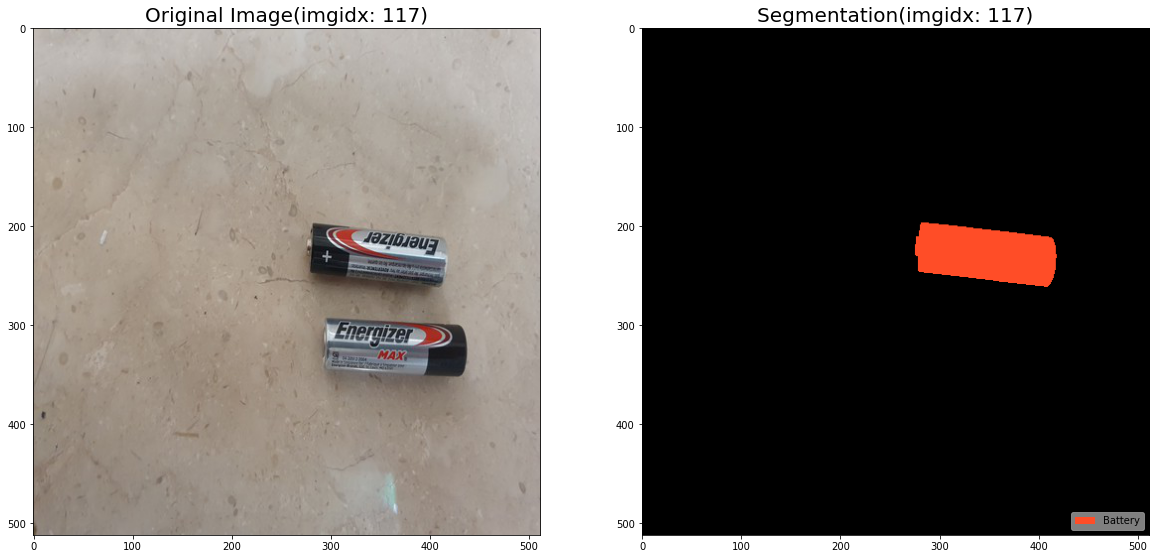

len(ann): 1


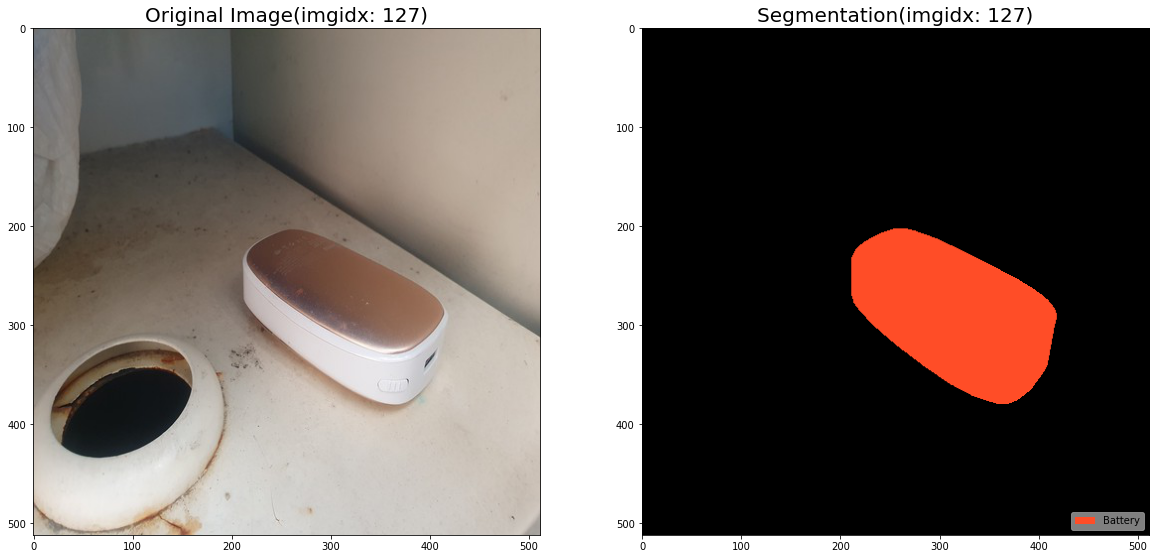

len(ann): 2


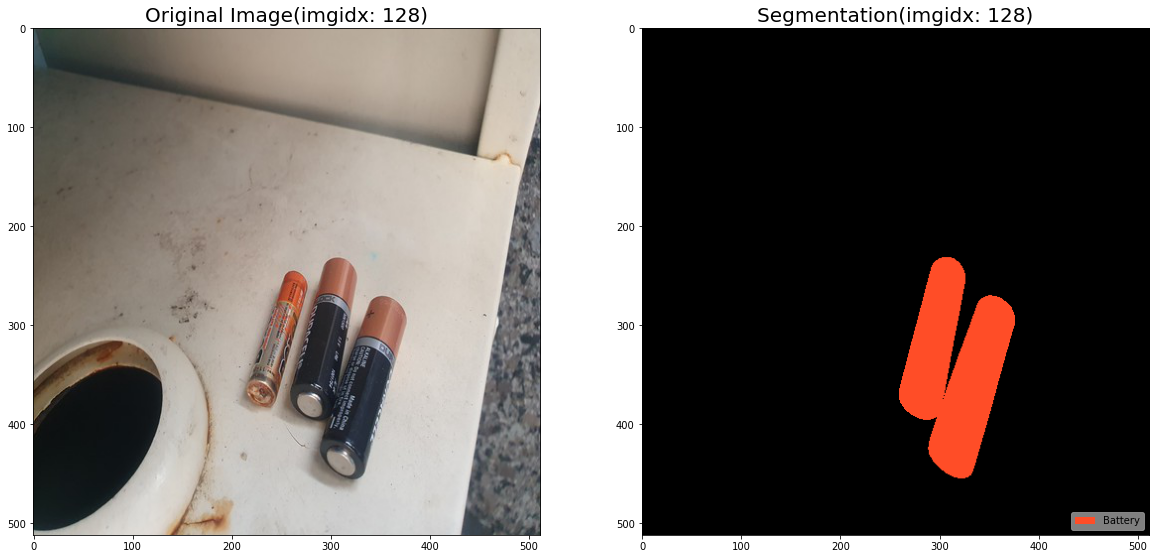

len(ann): 5


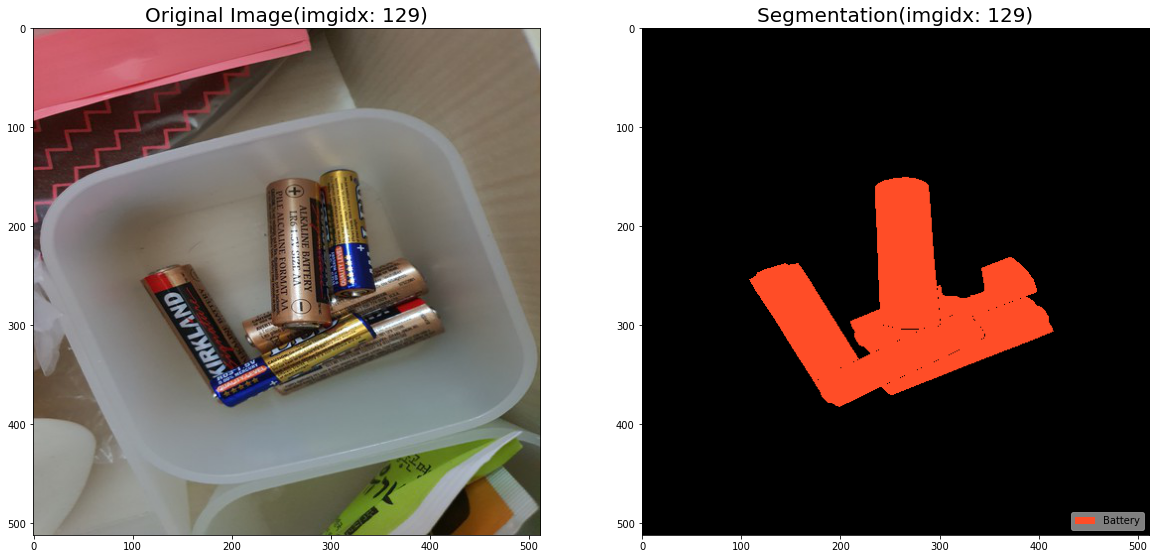

len(ann): 2


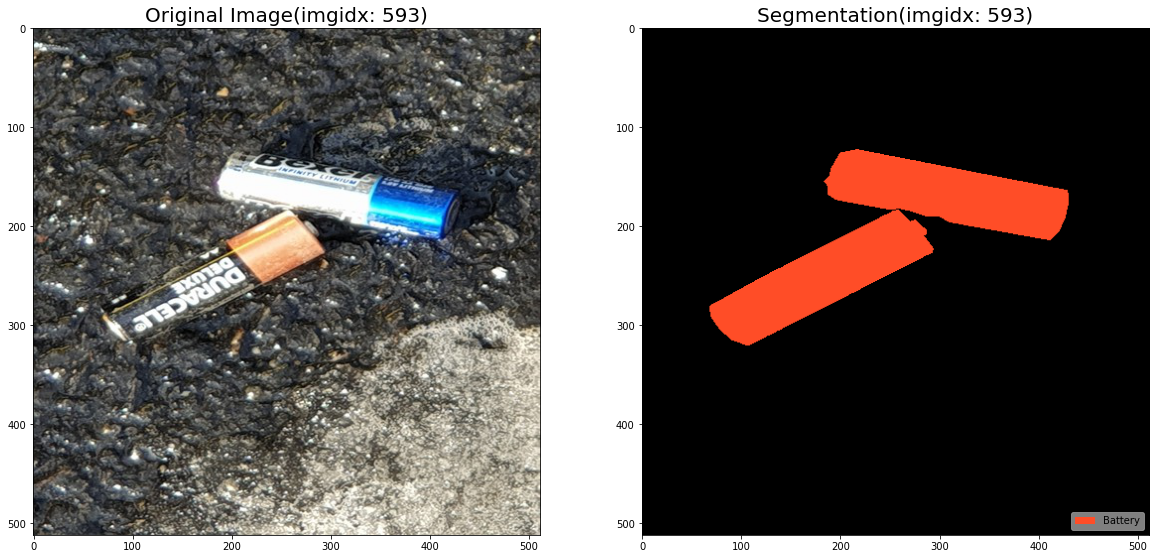

len(ann): 8


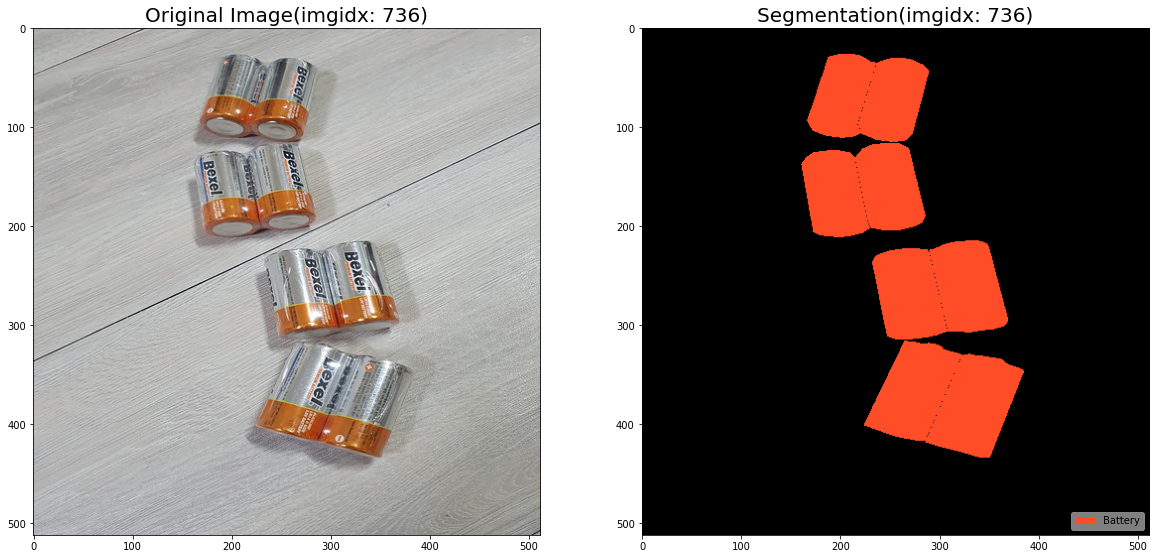

len(ann): 1


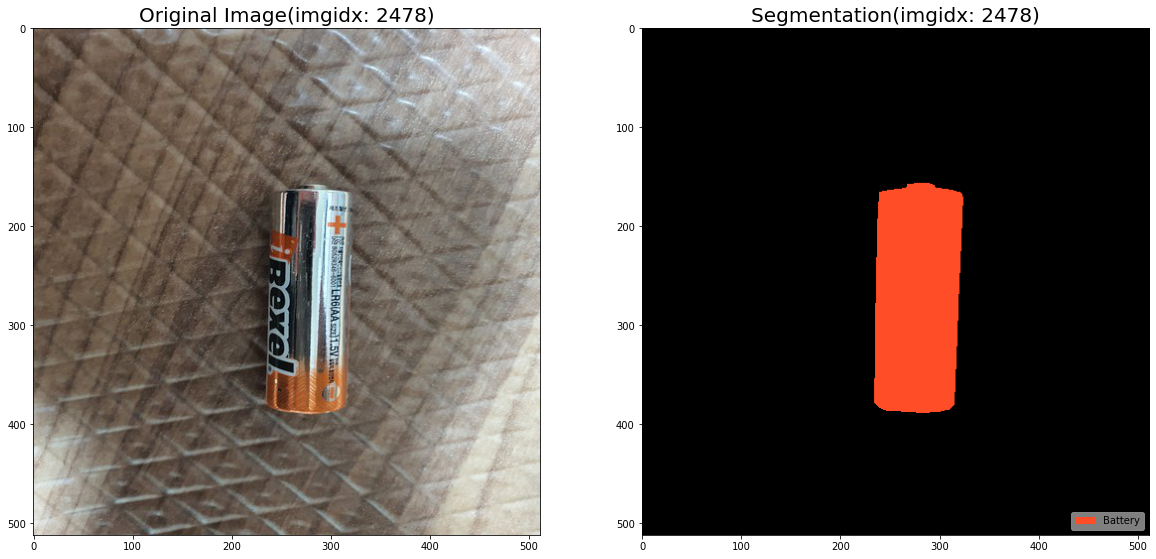

len(ann): 2


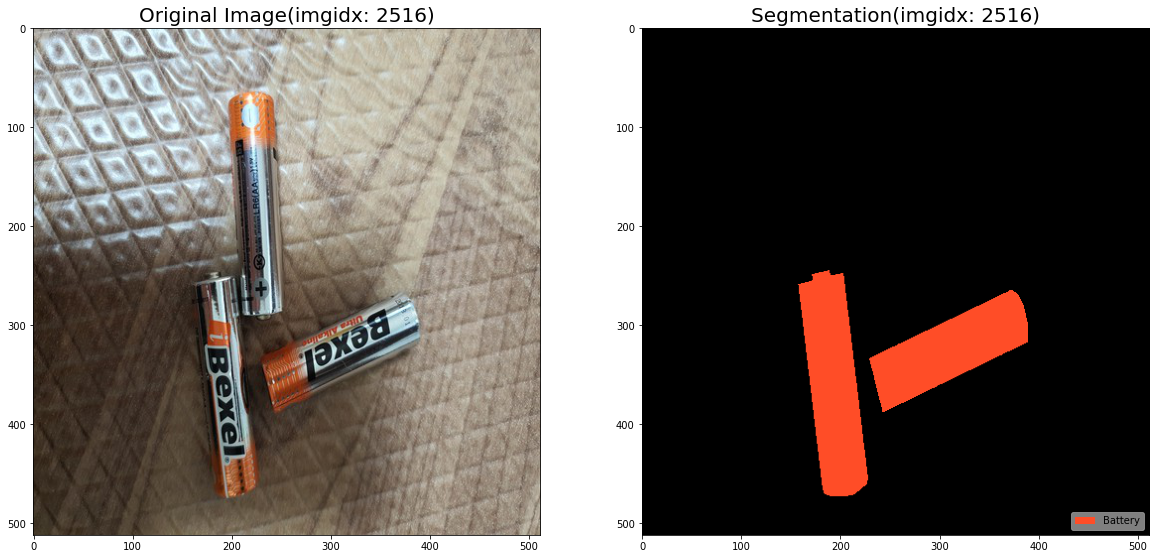

len(ann): 1


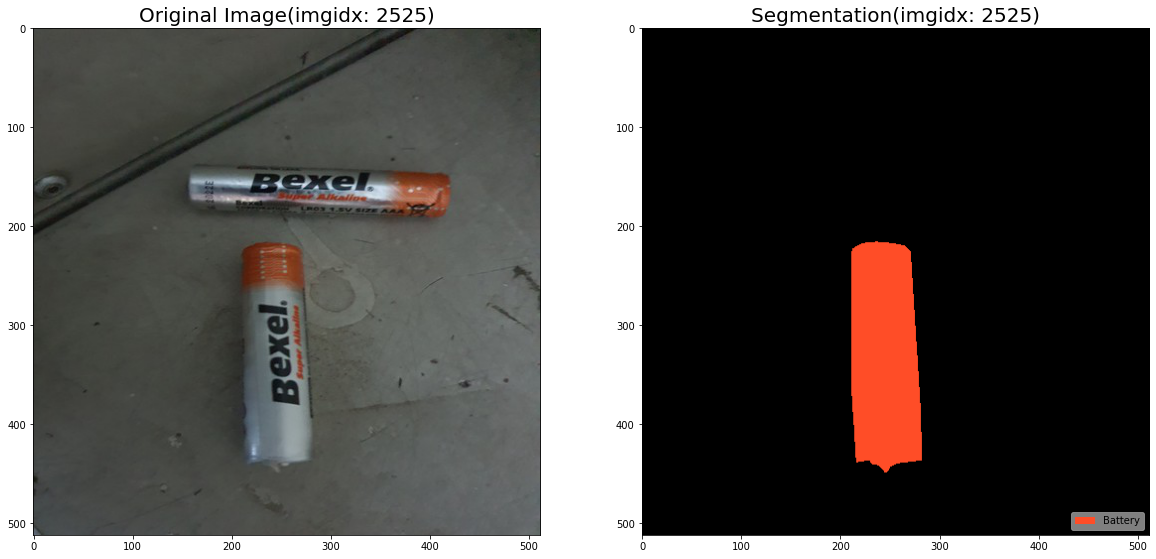

In [26]:
'''
카테고리에 해당하는 색상을 리턴해주는 함수
'''
def category_id_to_color(category_id):
    return plt.cm.rainbow(np.linspace(0, 1.0, 11)[category_id])[:3]


# categories_names: category_id와 이름을 매핑해주는 변수
categories_names = ['None']
for cat_dict in new_categories:
    categories_names.append(cat_dict['name'])

'''
해당 id의 이미지의
1) 원본 이미지
2) segmentation이 표시된 이미지
를 동시에 출력해주는 함수
'''
def show_original_segmentation(idx):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
    # 원본 이미지
    img = io.imread(os.path.join(dataset_folder, new_images[idx]['file_name']))
    ax1.imshow(img)

    imgidx = new_images[idx]['id']
    # segmentation이 표시된 이미지
    ann_ids = new_coco.getAnnIds(imgIds=imgidx) # 해당 이미지에 해당하는 annotation id들을 저장한 리스트
    ann = new_coco.loadAnns(ann_ids) # 해당 이미지에 해당하는 annotation 정보를 모두 담은 리스트
    print(f'len(ann): {len(ann)}')
    mask = np.zeros((new_images[0]['height'], new_images[0]['width'], 3))
    legend_colors = [] # 사진에 포함된 카테고리에 해당하는 색상을 저장 (추후 범례 표시를 위해)
    legend_titles = [] # 사진에 포함된 카테고리 이름을 저장 (추후 범례 표시를 위해)
    for ele in ann:
        category_id = ele['category_id']
        category = categories_names[category_id]
        color = category_id_to_color(category_id)
        mask[new_coco.annToMask(ele) == 1] = color
        if category not in legend_titles:
            legend_colors.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, fill=True))
            legend_titles.append(category)
    ax2.imshow(mask)

    ax1.set_title(f"Original Image(imgidx: {imgidx})", fontsize=20)
    ax2.set_title(f"Segmentation(imgidx: {imgidx})", fontsize=20)
    ax2.legend(legend_colors, legend_titles, loc='lower right', framealpha=.5)
    plt.show()

for idx in range(min(len(new_images), 10)):
    show_original_segmentation(idx)

## imgidx: 656 battery annotation 이상함